In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
%matplotlib inline

In [2]:
def measure_distortion():
    
    # prepare object points
    nx = 9
    ny = 6
    objpoints =[]
    imgpoints  = []
    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] =np.mgrid[0:9, 0:6].T.reshape(-1,2)


    # Get list of calibarion images
    fnames = glob.glob('camera_cal/*.jpg')

    for fname in fnames:
    
        # Read image
        img = cv2.imread(fname)

        # Convert image to gray
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # Check if corners are found
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            #Draw corners on the original image
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    return objpoints, imgpoints

In [3]:
def correct_distortion(img, objpoints, imgpoints):
    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    return undistort

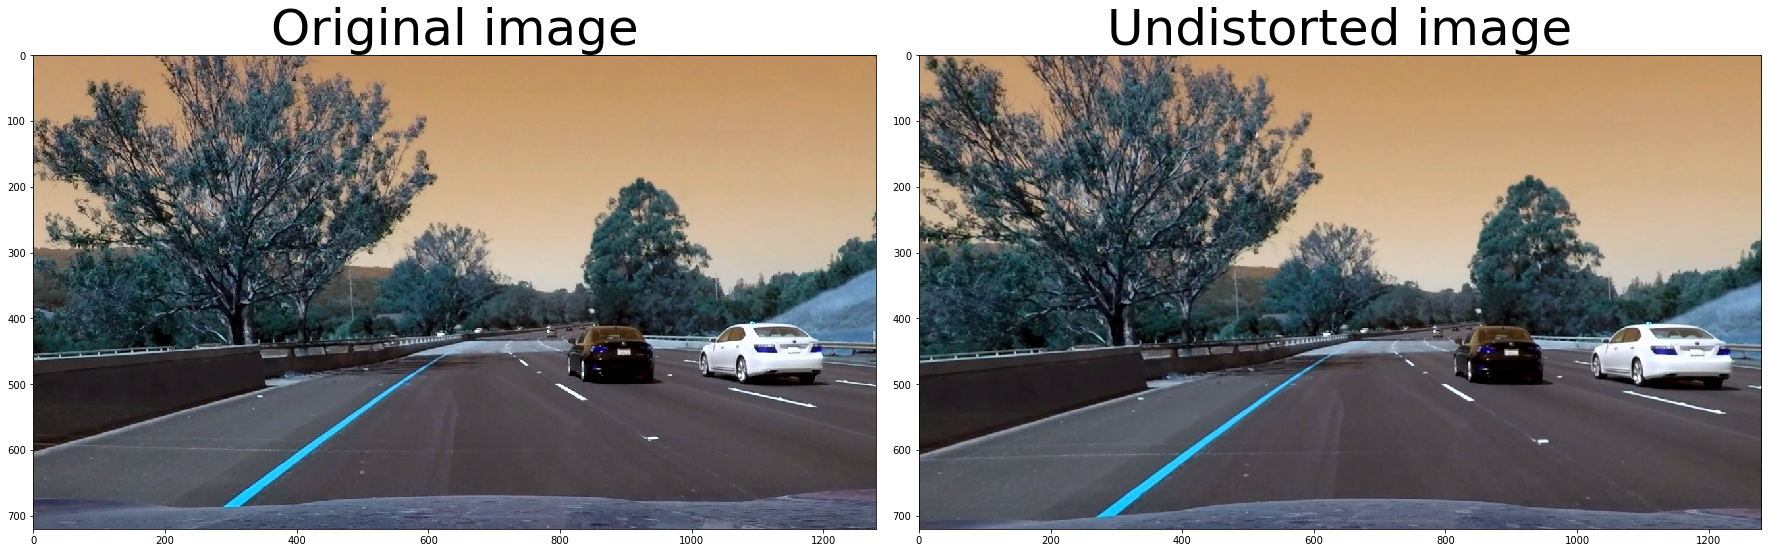

In [4]:
objpts, imgpts = measure_distortion()
img = cv2.imread('test_images/test6.jpg')

undist = correct_distortion(img, objpts, imgpts)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted image', fontsize=50)
plt.subplots_adjust(left=0, right=1, top=0.8, bottom=0)

In [5]:
# perform perspective transform
def warp(img):
    # Get image size
    img_size = (img.shape[1], img.shape[0])
    
    # Define source coordinate points
    src = np.float32([[537, 500],[278, 697],[1082, 675], [767,500]])
    
    # Define desired  coordinate points
    dst = np.float32([[276, 0],[278, 697],[1082, 675],[1074, 0]])
    
    # get perspective transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # warp the image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

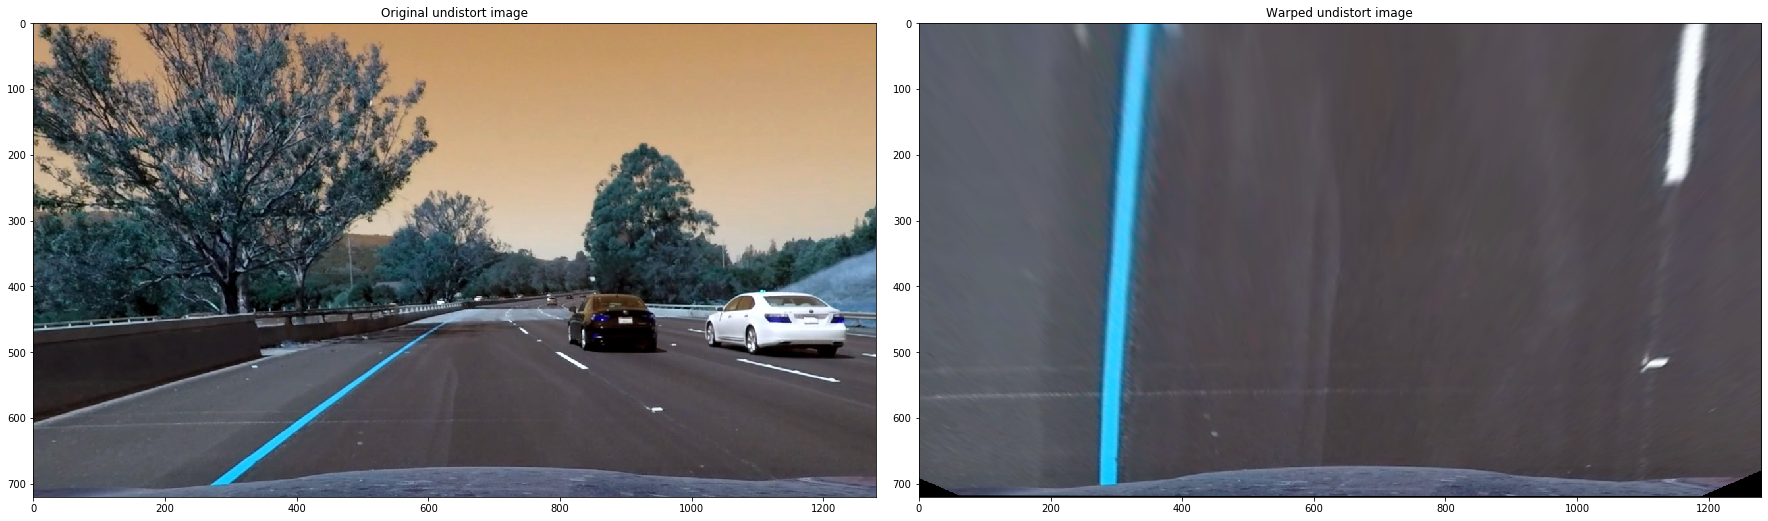

In [6]:
warped = warp(undist)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()                            
ax1.imshow(undist)
ax1.set_title('Original undistort image')
ax2.imshow(warped)
ax2.set_title('Warped undistort image')
f.subplots_adjust(left=0, right=1, top=0.8, bottom=0)

In [7]:
# Apply gradient
def apply_sobel(img, orient='x', thresh_min=0, thresh_max=255):
   
    # convert image to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Take gradient in x or y direction
    if orient =='x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    else:
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    
    # Covert pixels to 8 bits 0-255
    scaled_sobel = (255*abs_sobel/np.max(abs_sobel))
    plt.imshow(scaled_sobel)
    
    # Create mask where strong gradient within the threshold set to 1
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=thresh_min) & (scaled_sobel<=thresh_max)]=1
    return binary_output
    
    

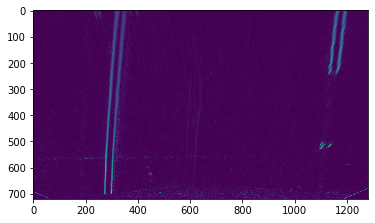

In [8]:
binary_image = apply_sobel(warped, orient='x', thresh_min=30, thresh_max=100)

Text(0.5, 1, 'binary_image warped image')

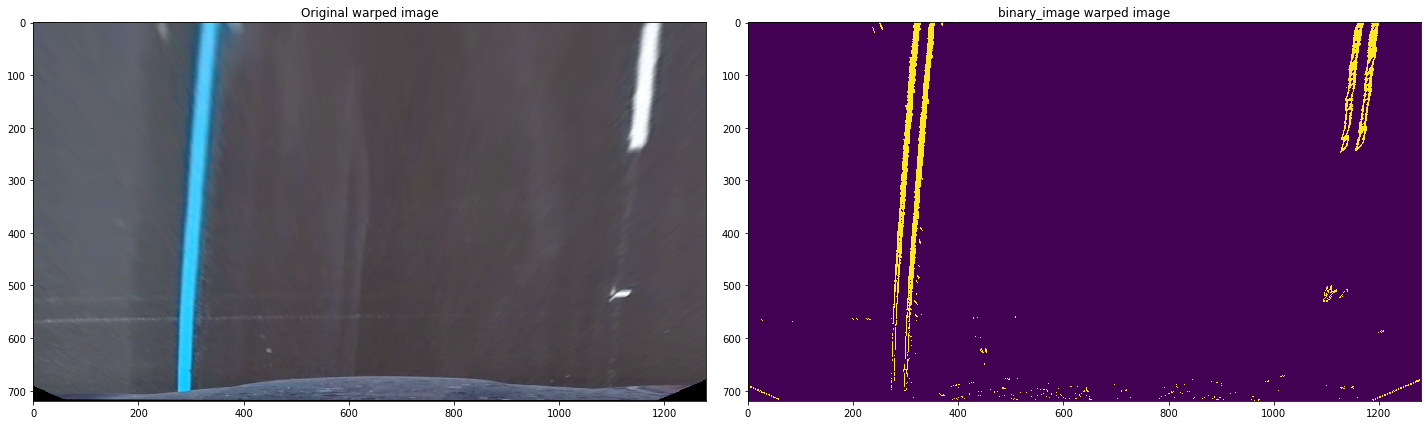

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('Original warped image')

ax2.imshow(binary_image)
ax2.set_title('binary_image warped image')


In [10]:
# Apply gradient magnitude
def apply_sobel_mag(img, kernel_size=3, thresh_min=0, thresh_max=255):
   
    # convert image to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Take gradient in x and y direction
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size))
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size))
    
    # Calculate magnitude of the gradient
    gradmag = np.sqrt(abs_sobel_x**2+abs_sobel_y**2)
    
    # Covert pixels to 8 bits 0-255
    scaled_sobel = (255*gradmag/np.max(gradmag))
    plt.imshow(scaled_sobel)
    
    # Create mask where strong gradient within the threshold set to 1
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=thresh_min) & (scaled_sobel<=thresh_max)]=1
    return binary_output
    

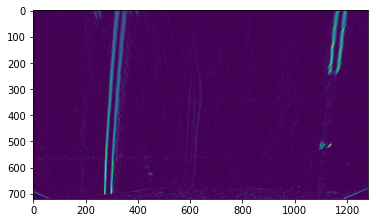

In [11]:
binary_image2 = apply_sobel_mag(warped, kernel_size=15, thresh_min=50, thresh_max=150)

Text(0.5, 1, 'binary_image warped image')

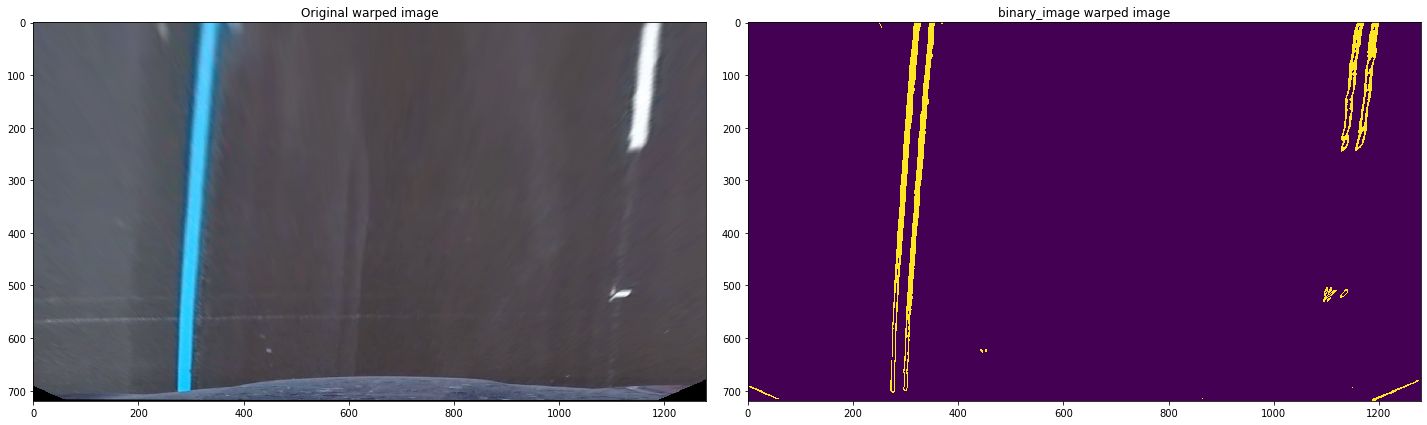

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('Original warped image')

ax2.imshow(binary_image2)
ax2.set_title('binary_image warped image')


In [13]:
# Apply gradient direction
def apply_sobel_dir(img, kernel_size=3, thresh_min=0, thresh_max=np.pi/2):
   
    # convert image to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Take gradient in x and y direction
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size))
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size))
    
    # Calculate magnitude of the gradient
    graddir= np.arctan2(abs_sobel_y, abs_sobel_x)
    
    # Covert pixels to 8 bits 0-255
    #scaled_sobel = (255*gradmag/np.max(gradmag))
    plt.imshow(graddir)
    
    # Create mask where strong gradient within the threshold set to 1
    binary_output = np.zeros_like(graddir)
    binary_output[(graddir>=thresh_min) & (graddir<=thresh_max)]=1
    return binary_output
    

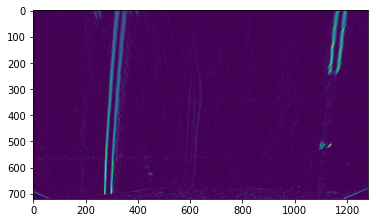

In [14]:
binary_image3 = apply_sobel_mag(warped, kernel_size=15, thresh_min=0.7, thresh_max=1.3)

Text(0.5, 1, 'binary_image warped image')

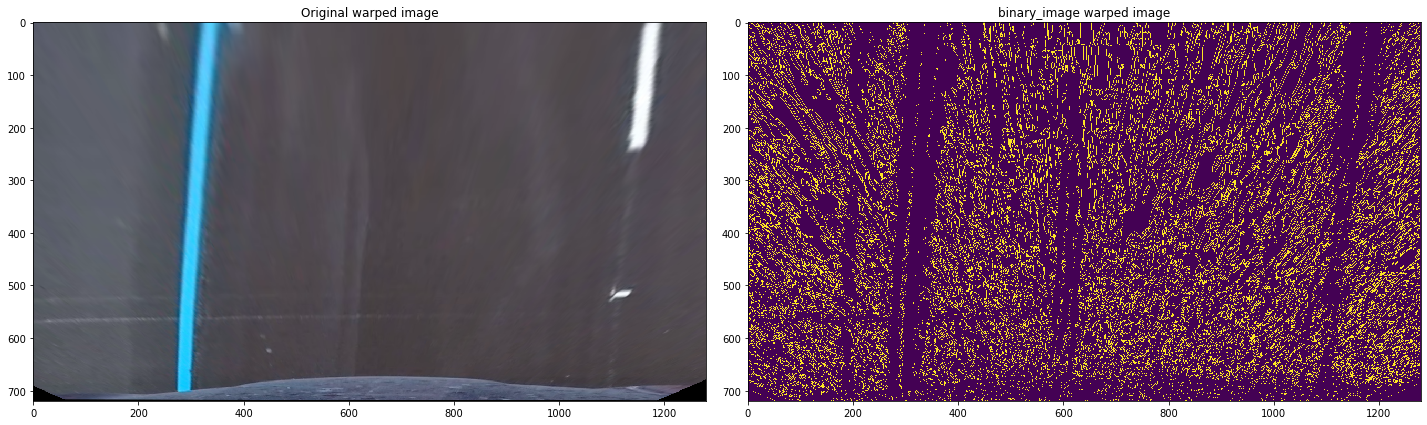

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('Original warped image')

ax2.imshow(binary_image3)
ax2.set_title('binary_image warped image')


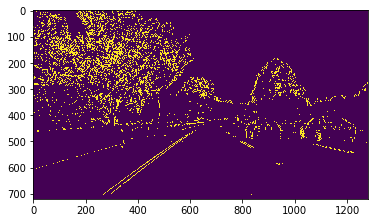

In [16]:
gradx = apply_sobel(undist, orient='x', thresh_min=30, thresh_max=150)
grady = apply_sobel(undist, orient='y', thresh_min=30, thresh_max=150)
grad_mag = apply_sobel_mag(undist, kernel_size=3, thresh_min=30, thresh_max=150)
grad_dir = apply_sobel_mag(undist, kernel_size=3, thresh_min=0.7, thresh_max=1.3)

combined = np.zeros_like(grad_dir)
combined[((gradx == 1) & (grady==1) |(grad_mag == 1) & (grad_dir==1) )] =1
plt.imshow(combined)

In [18]:
def color_thresh(img, thresh=(0, 255), desired_color_channel='hls'):
    # convert image to desired color space
    if desired_color_channel == 'hls':
        # convert image to hls color space
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        # Extract s-channel
        s_channel = hls[:,:,2]
    elif desired_color_channel == 'hsv':
        # convert image to hsv color space
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # Extract s-channel
        s_channel = hsv[:,:,1]
    
    # Create binary image
    binary_output = np.zeros_like( s_channel)
    # Apply threshold
    binary_output[(s_channel>thresh[0]) & (s_channel>=thresh[1])]=1
    # Return the binary output
    return binary_output
    


In [25]:
result = color_thresh(undist, thresh=(150, 255), desired_color_channel='hls')

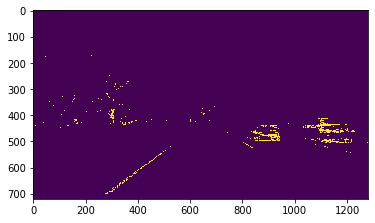

In [26]:
plt.imshow(result)